# Working with unlabeled data - Clustering analysis

**Clustering analysis** is a category of **unsupervised learning** that allows us to discover hidden structures in data. 

## Grouping objects with k-means

One of the most popular clustering algorithms is **k-means** which is very efficient and is good for finding sferic shapes in data. One of the major drawbacks is that we have to feed it a priori with the **k**, the number of clusters.

In [1]:
from sklearn.datasets import make_blobs

In [2]:
x, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=.5,
                  shuffle=True,
                  random_state=0)

In [3]:
import matplotlib.pyplot as plt

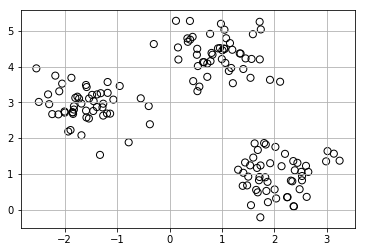

In [4]:
plt.scatter(x[:, 0],
            x[:, 1],
            edgecolors='black',
            facecolors='none',
            marker='o',
            s=50)
plt.grid()
plt.show()

In reality we don't know any category information about samples, so our goal is to group them according to their feature similarities. We can do this by using k-means, the algorithm can be summarized as:

1. Randomly pick $k$ centroids from the sample points as initial cluster centers
2. Assign each sample to the nearest centroid $\mu^{(j)}$
3. Move the centroids to the center of the samples that were assigned to it
4. Repeat steps 2 and 3 until the cluster assignments do not change

But how do we measure similarity? We can define *similarity* as the opposite of distance, and a commonly used distance is the **squared Euclidean distance**:

$$
d(x,y)^2=\sum_{j=1}^{m}(x_j-y_j)^2=||x-y||_{2}^{2}
$$

In this case $j$ refers to the jth dimension of the sample points, we will use $i$ and $j$ to indicate sample index and cluster index, respectively.

Based on the previously defined distance now we have an optimization problem.

In [5]:
from sklearn.cluster import KMeans

In [6]:
km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(x)

In the code above we set the number of clusters to 3 (*n_clusters=3*), then we set *n_init=10* to run the algo 10 times independently with different random centroids and choose the one with the lowest SSE. The [**KMeans**](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) implementation stops early if it reaches convergence. We can control the tolerance of the changes in the SSE with *tol* argument, which in this case we set equal to 0.0001, the larger the tolerance the earlier the convergence.

### K-means++

One of the issues with choosing random centroids is that we have to run multiple k-means at the same time to ensure convergence and/or a good result. Another way to deal with this issue is to place the initial centroids far away from each other, this approach is called **k-means++** and we can use it by simply passing it to the *init* parameter of **KMeans** (which is actually the default)

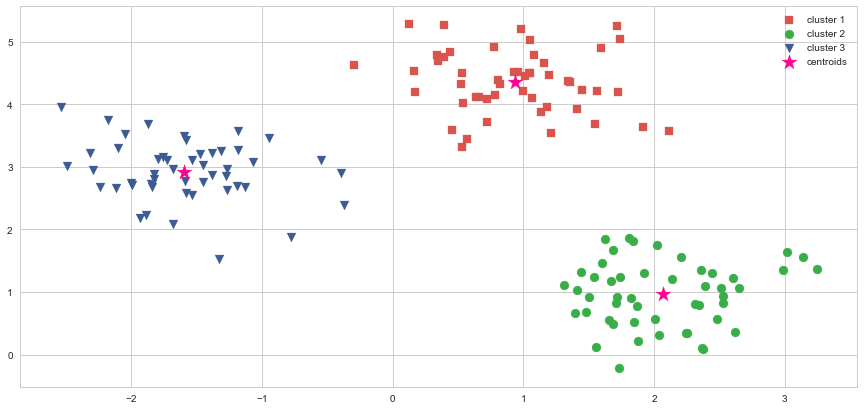

In [7]:
import seaborn as sns
sns.set(style='whitegrid', context='notebook', rc={"figure.figsize": (15, 7)})

plt.scatter(x[y_km == 0, 0],
            x[y_km == 0, 1],
            s=80,
            c=sns.xkcd_rgb["pale red"],
            marker='s',
            label='cluster 1')
plt.scatter(x[y_km == 1, 0],
            x[y_km == 1, 1],
            s=80,
            c=sns.xkcd_rgb["medium green"],
            marker='o',
            label='cluster 2')
plt.scatter(x[y_km == 2, 0],
            x[y_km == 2, 1],
            s=80,
            c=sns.xkcd_rgb["denim blue"],
            marker='v',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250,
            c=sns.xkcd_rgb["hot pink"],
            marker='*',
            label='centroids')
plt.legend()
plt.show()

### Hard vs soft clustering

**Hard clustering** describes algos that assign each sample of a dataset to one cluster - for instance k-means - while **soft clustering** (or **fuzzy clustering**) assign a sample to one or more clusters. A popular example is **fuzzy C-means (FCM)**.

**FCM** procedure is very similar to k-means, but instead of getting an assignemnt we get probabilities for each point belonging to each cluster. Unfortunately FCm is not implemented in scikit-learn, however in practice it has been proven that k-means and FCM produce very similar results.

### Elbow method for k

Since in unsupervised learning we can't check whether the clusters are "correct" we have to use intrinsic metrics, in this case we will use the within-cluster SSE, which is accessible via the **inertia\_** attribute in a fitted **KMeans** object

In [8]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


The **elbow method** is a visual way to identify an optimal value for k

In [9]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(x)
    distortions.append(km.inertia_)

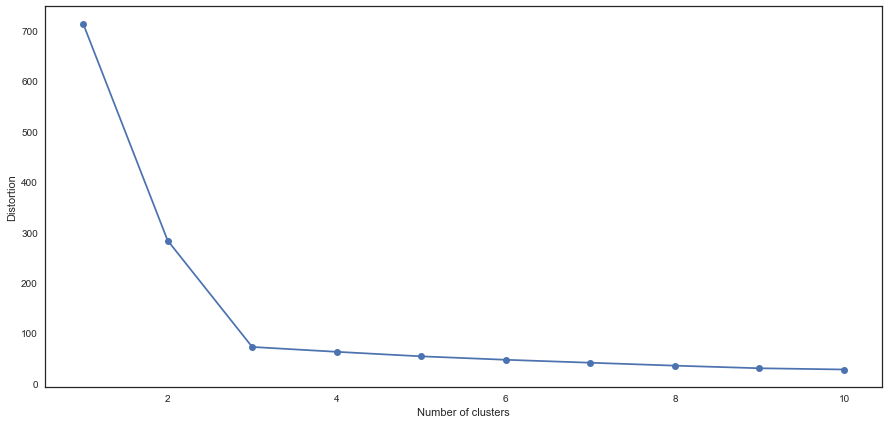

In [10]:
sns.set(style='white', context='notebook', rc={"figure.figsize": (15, 7)})
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

As we can see, the elbow is located at *k=3*, which is a good choice for this dataset.

### Clustering quality via silhouette plots

The **silhouette coefficient** is bounded in the range -1 to 1, and it is available as [**silhouette_samples**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) in the **metrics** modules.

In [11]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(x)

In [12]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

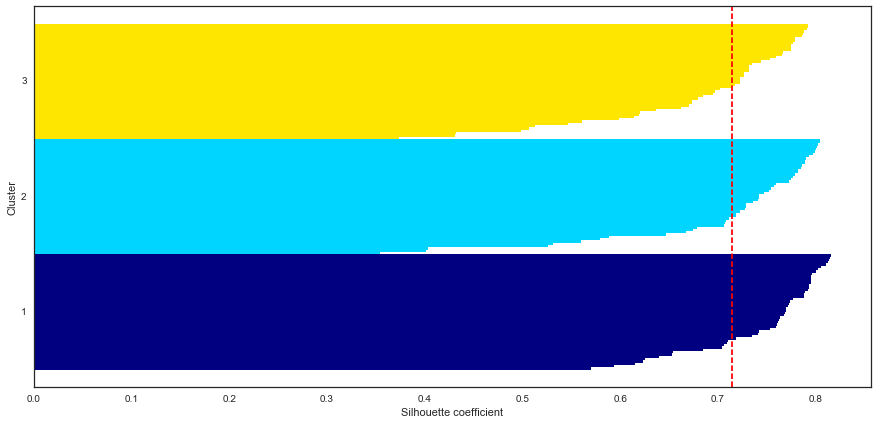

In [13]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(x, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals,
             height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

## Organizing clusters as a hierarchical tree

**Hierarchical clustering** allows us to plot **dendrograms** which can help with the interpretation and we don't need to specify the number of clusters upfront.

The two main approaches are **agglomerative** and **divisive** hierarchical clustering. In divisive clustering we start with one cluster containing all samples and we iteratively split the cluster into smaller clusters until each cluster only contains one sample.

We will focus on agglomerative clustering which takes the opposite approach by using two standard algorithms: **single linkage** and **complete linkage**. With single linkage we compute the distances between the most similar members for each pair of clusters and merge the two clusters which distance is the smallest, complete linkage is similar, but we compare the most dissimilar instead.

Now let's generate a datset we can work with

In [14]:
import pandas as pd
import numpy as np

In [15]:
np.random.seed(123)
variables = ['x', 'y', 'z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
x = np.random.random_sample([5,3])*10
df = pd.DataFrame(x, columns=variables, index=labels)
df

,x,y,z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


### Hierarchical clustering on a distance matrix

To calculate the distance matrix we will use the [**pdist**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) function from SciPy

In [16]:
from scipy.spatial.distance import pdist, squareform

In [17]:
row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')), columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


Above we got the Euclidean distance matrix, next we will apply the complete linkage agglomeration using the [**linkage**](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) function which returns a **linkage matrix**.

But before let's take a look at the function documentation:

In [18]:
from scipy.cluster.hierarchy import linkage
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean')
    Performs hierarchical/agglomerative clustering on the condensed
    distance matrix y.
    
    y must be a :math:`{n \choose 2}` sized
    vector where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    An :math:`(n-1)` by 4  matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents the number of original
    observations in the newly formed cluster.
    
    The following linkage methods are used to compute the distance
  

> As we can see above we can use a `condensed distance matrix` (upper triangular) as an input. We may even pass to the funztion the original values and use 'euclidean' as a metric

In [19]:
# Condensed distance matrix
row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust'],
             index=['cluster %d' % (i +1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [20]:
# Input sample matrix
row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust'],
             index=['cluster %d' % (i +1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


Now we can visualize clustering with a dendrogram

In [21]:
from scipy.cluster.hierarchy import dendrogram

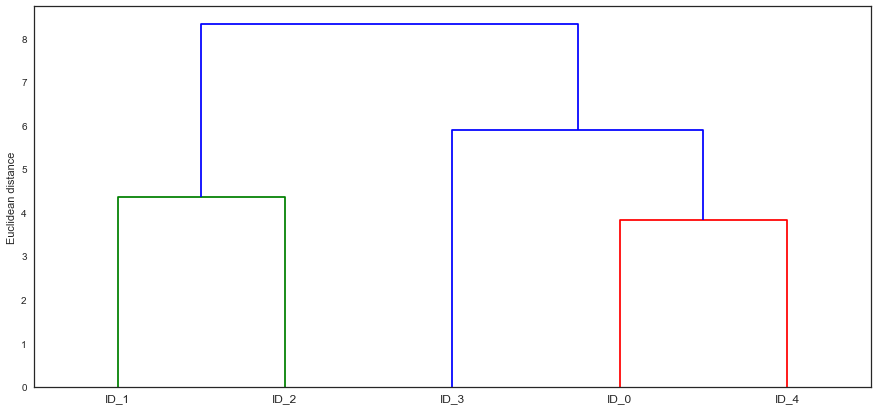

In [22]:
row_dendr = dendrogram(row_clusters, labels=labels)
plt.ylabel('Euclidean distance')
plt.show()

### Dendrograms with heat map

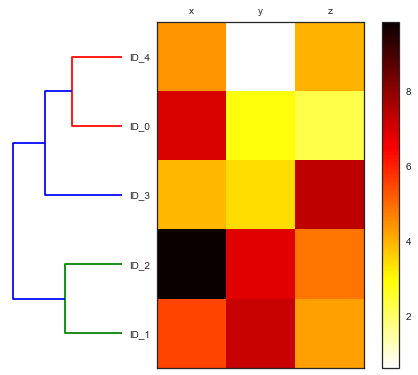

In [23]:
fig = plt.figure(figsize=(8,8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

row_dendr = dendrogram(row_clusters, orientation='left')
df_rowclust = df.ix[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

for i in axd.spines.values():
    i.set_visible(False)

axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

### Agglomerative clustering via scikit-learn

We can use the [**AgglomerativeClustering**](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) implementation in scikit-learn. This method lets us decide how many clusters the algorithm will return, in this way it gets easier to prune the hierarchical tree cluster.

We will now cluster the samples into 2 groups

In [24]:
from sklearn.cluster import AgglomerativeClustering

In [26]:
ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(x)
print('Cluster labels: %s' % labels)

Cluster labels: [0 1 1 0 0]


## Density based clustering with DBSCAN

**Density-Based Spatial Clustering of Applications with Noise (DBSCAN)** is a clustering algorithm based on density, where we define it as the number of points within a specified radius $\epsilon$.

In DBSCAN each sample is assigned a special label:

- **Core point**: at least a specified number of neighbors (*MinPts*) falls within $\epsilon$
- **Border point**: has fewer neighbors than *MinPts*, but lies whithin $\epsilon$ of a *core point*
- **Noise points**: all other are noise points

After labeling the algorithm assigns each core point to a cluster, and then adds to it the border points. It's easy to see right away that DBSCAN doesn't assume a spherical shape for clusters and it won't add all points to a cluster effectively cutting down on noise.

In [27]:
from sklearn.datasets import make_moons

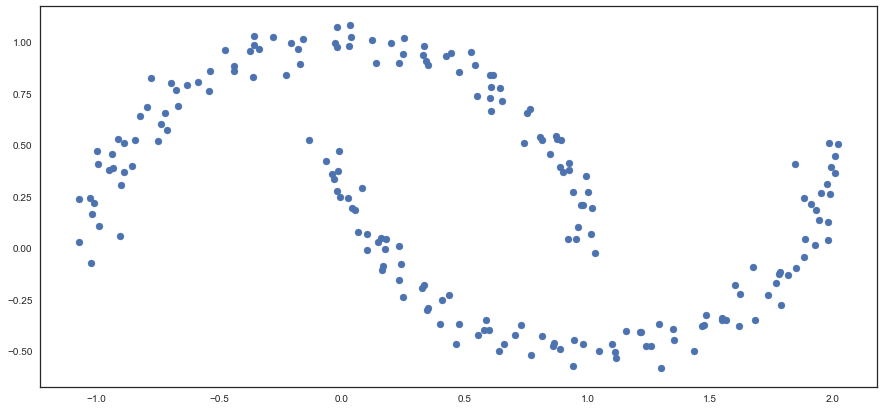

In [28]:
x, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(x[:, 0], x[:, 1])
plt.show()

Now we can compare **k-means**, **hierarchical clustering** and **DBSCAN** on the generated dataset.

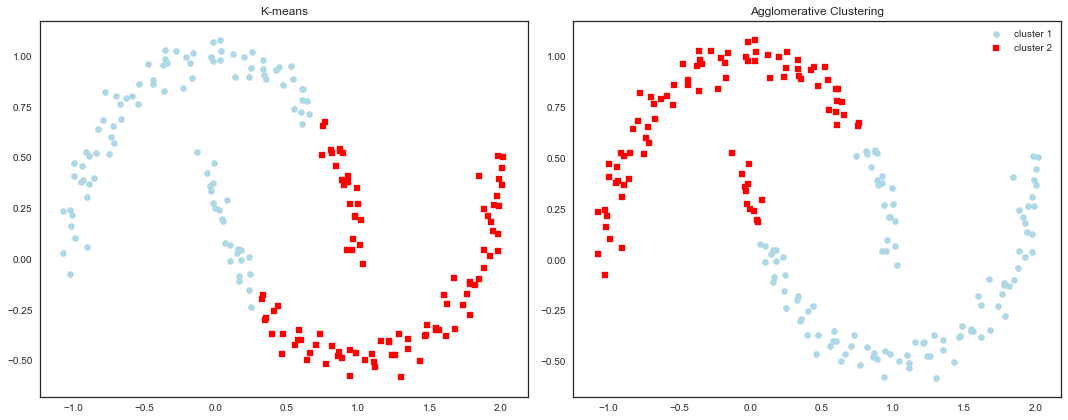

In [32]:
# K-Means
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(x)

ax1.scatter(x[y_km == 0, 0],
            x[y_km == 0, 1],
            c='lightblue',
            marker='o',
            s=40,
            label='cluster 1')
ax1.scatter(x[y_km == 1, 0],
            x[y_km == 1, 1],
            c='red',
            marker='s',
            s=40,
            label='cluster 2')
ax1.set_title('K-means')

# Agglomerative clustering
ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
y_ac = ac.fit_predict(x)

ax2.scatter(x[y_ac == 0, 0],
            x[y_ac == 0, 1],
            c='lightblue',
            marker='o',
            s=40,
            label='cluster 1')
ax2.scatter(x[y_ac == 1, 0],
            x[y_ac == 1, 1],
            c='red',
            marker='s',
            s=40,
            label='cluster 2')
ax2.set_title('Agglomerative Clustering')
plt.legend()
plt.tight_layout()
plt.show()

Both clustering algorithms have issues identifying the two cluster shapes, now let's see what DBSCAN can do

In [33]:
from sklearn.cluster import DBSCAN

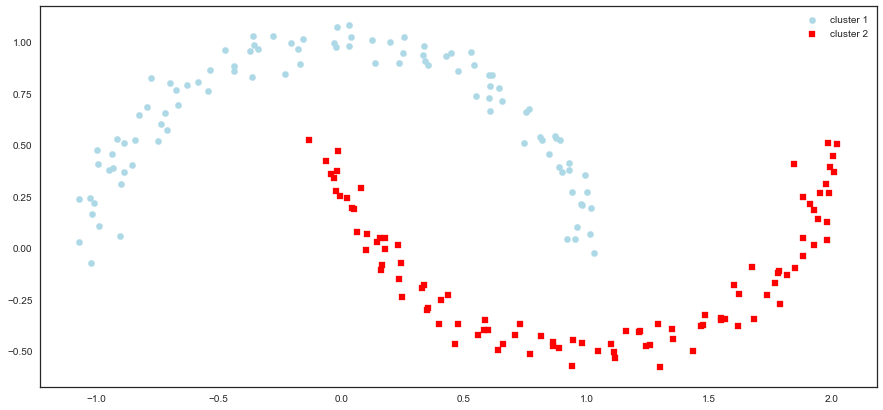

In [34]:
db = DBSCAN(eps=0.2,
            min_samples=5,
            metric='euclidean')
y_db = db.fit_predict(x)

plt.scatter(x[y_db == 0, 0],
            x[y_db == 0, 1],
            c='lightblue',
            marker='o',
            s=40,
            label='cluster 1')
plt.scatter(x[y_db == 1, 0],
            x[y_db == 1, 1],
            c='red',
            marker='s',
            s=40,
            label='cluster 2')
plt.legend()
plt.show()